In [1]:
import os
import cv2
import time
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import trange
from scipy.spatial import distance
from collections import OrderedDict
from imgaug import augmenters as iaa
from IPython.display import clear_output

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.optimize import linear_sum_assignment as linear_assignment

from lib.utils import stl10
from lib.utils_torch import Identity, Net34, clustering_acc
from lib.utils import normalize, read_all_imgs, extractor, plot_loss

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

(100000, 96, 96, 3) (5000, 96, 96, 3) (5000,) (200, 96, 96, 3) (200,)


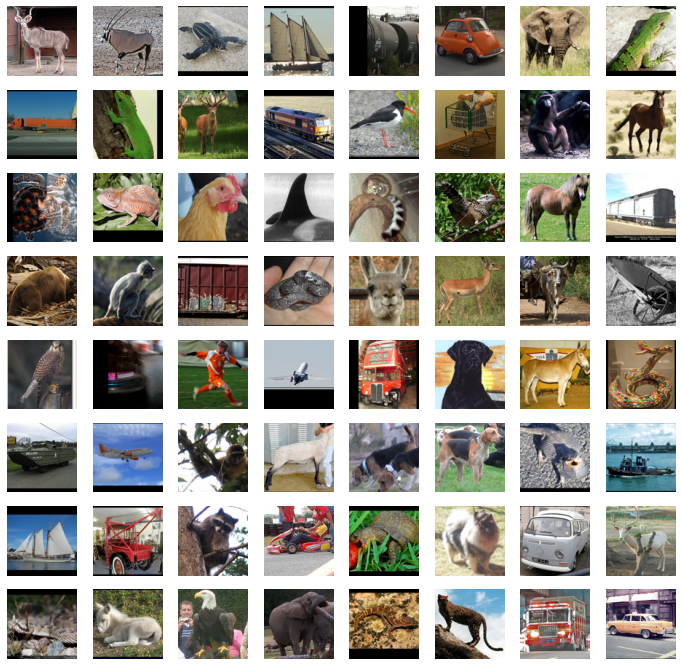

In [2]:
"""
Loading the dataset
"""

result = stl10("./data/stl10_binary")

result["test_X"] = result["test_X"][:200]
result["test_y"] = result["test_y"][:200]
mean = np.mean(result["unlabeled_X"][:200]/255.)
std = np.std(result["unlabeled_X"][:200]/255.)

print(result["unlabeled_X"].shape,
      result["train_X"].shape,
      result["train_y"].shape,
      result["test_X"].shape,
      result["test_y"].shape)

plt.figure(figsize=(12,12))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,i*8+j+1)
        plt.axis("off")
        plt.imshow(result["unlabeled_X"][i*8+j])
plt.show()

In [3]:
"""
Loading the model
"""

batch_size = 2
img_shape = 370
gpus = []
model_path = "./models/res34_model_training_with_STL.pth"

if len(gpus)>0:
    device = torch.device("cuda:"+str(gpus[0]))
else:
    device = torch.device("cpu")

my_model_pre = Net34().to(device)
if len(gpus)>1: my_model_pre = nn.DataParallel(my_model, gpus)

if len(gpus)>0:
    state_dict = torch.load(model_path, map_location="cuda:"+str(gpus[0]))
else:
    state_dict = torch.load(model_path, map_location="cpu")
state_dict_ = OrderedDict([])
for name in state_dict.keys():
    name_ = name.replace("module.", "")
    state_dict_[name_] = state_dict[name]
my_model_pre.load_state_dict(state_dict_)
my_model_pre = my_model_pre.eval()

In [5]:
"""
Calculating images' features
"""
hs_test = []
n_round = int(np.ceil(len(result["test_X"]) / batch_size))
_indices = [i for i in range(len(result["test_X"]))]
for i_round in trange(n_round):
    indices = _indices[i_round * batch_size : (i_round+1) * batch_size]
    Xs = []
    for pic in result["test_X"][indices]:
        Xs.append(cv2.resize(pic, (img_shape,img_shape)))
    Xs = np.array(Xs)
    Xs = ((Xs.transpose([0,3,1,2])/255.-mean)/std)
    Xs = torch.from_numpy(Xs.astype(np.float32)).to(device)

    with torch.no_grad():
        hs_ = my_model_pre(Xs)
    hs_test.append(hs_.detach().cpu().numpy())

hs_test = np.concatenate(hs_test)
print(hs_test.shape)

100%|██████████| 100/100 [00:55<00:00,  1.82it/s]

(200, 512)


In [6]:
"""
Calculating the accuracy
"""

kmeans = KMeans(n_clusters=10, n_init=100)
# Train K-Means.
y_pred_kmeans = kmeans.fit_predict(hs_test)

clustering_acc(result["test_y"], y_pred_kmeans)

0.42

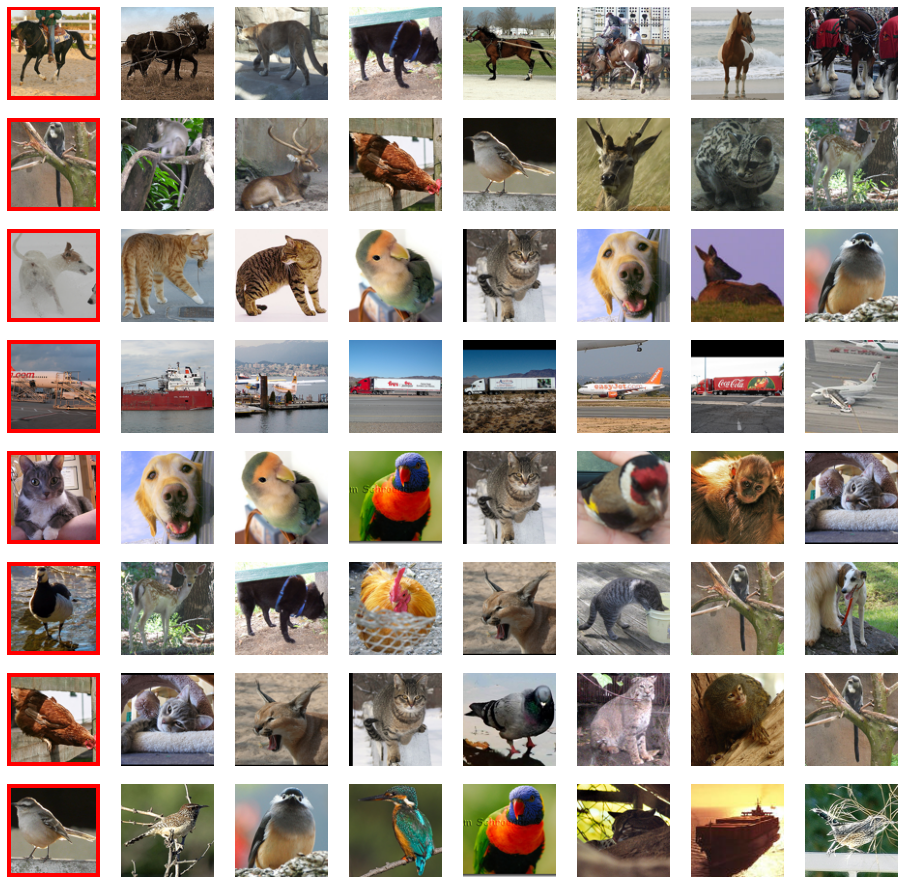

In [7]:
"""
Example of looking for neighbours
"""

output = []
for i in range(8):
    dists = distance.cdist(hs_test[i:i+1], hs_test, 'minkowski', p=2.).reshape([-1])
    output.append(sorted(range(len(dists)), key=lambda k: dists[k]))

plt.figure(figsize=(16,16))
for i in range(8):
    plt.subplot(8,8,i*8+1)
    plt.imshow(result["test_X"][i])
    rect = patches.Rectangle((1, 1), 93, 93, linewidth=4, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.axis("off")
    for j,_id_g in enumerate(output[i][1:8]): # removing the first image because it must be itself
        plt.subplot(8,8,i*8+j+2)
        plt.imshow(result["test_X"][_id_g])
        plt.axis("off")
plt.show()